<a href="https://colab.research.google.com/github/peasant87/iesb-deep-learning/blob/master/Captcha_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importar bibliotecas e definir parametros iniciais

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras import layers, callbacks
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils, to_categorical

import cv2 as cv
import string

%matplotlib inline

Definir simbolos possuíveis no captcha (alfabeto e algorítimos de 0 à 9).

Definir tamanho da imagem (X,Y,Z)
X = Altura
Y = Largura
Z = Quantidade de canais (RGB = 3, Preto/Branco = 1)

In [0]:
symbols = string.ascii_lowercase + "0123456789"
num_symbols = len(symbols)
img_shape = (50,200,1)

### Criar modelo no Keras

In [0]:
def create_model():
  img = layers.Input(shape=img_shape)
  
  conv1 = layers.Conv2D(16,(3,3), padding="same", activation="relu")(img)
  mp1 = layers.MaxPooling2D(padding="same")(conv1)
  
  conv2 = layers.Conv2D(32,(3,3), padding='same', activation='relu')(mp1)
  mp2 = layers.MaxPooling2D(padding='same')(conv2)
  
  conv3 = layers.Conv2D(32,(3,3), padding='same', activation='relu')(mp2)
  bn = layers.BatchNormalization()(conv3)
  mp3 = layers.MaxPooling2D(padding='same')(bn)
  
  #criar 5 ramos, cada um trabalhará com uma letra
  flat = layers.Flatten()(mp3)
  outs = []
  for _ in range(5):
    dens1 = layers.Dense(64, activation='relu')(flat)
    drop = layers.Dropout(0.5)(dens1)
    res = layers.Dense(num_symbols, activation='sigmoid')(drop)
    
    outs.append(res)
  
  model = Model(img, outs)
  model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics=["accuracy"])
  return model

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
images_path = '/content/drive/My Drive/Colab Notebooks/captcha/samples'

In [0]:
n_samples = len(os.listdir(images_path))

In [38]:
model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 50, 200, 1)   0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 50, 200, 16)  160         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 25, 100, 16)  0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 25, 100, 32)  4640        max_pooling2d_7[0][0]            
__________________________________________________________________________________________________
max_poolin

### Trabalhando imagens

Definir função de pré-processamento
Realizar pré-processamento
Separar em arquivo de teste e treino

In [0]:
def preprocess_data():
  images = os.listdir(images_path)
  n_samples = len(images)
  X = np.zeros((n_samples, 50,200,1))
  y = np.zeros((5, n_samples, num_symbols))
  
  for i, pic in enumerate(images):
    img = cv.imread(os.path.join(images_path,pic),cv.IMREAD_GRAYSCALE)
    pic_target = pic[:-4]
    if len(pic_target) < 6:
      #definir escala e refatorar imagem
      img = img / 255.0
      img = np.reshape(img,(50,200,1))
      
      #definir alvos e codifica-los usando OneHotEncoding
      targs = np.zeros((5,num_symbols))
      for j,l in enumerate(pic_target):
        ind = symbols.find(l)
        targs[j,ind] = 1
      X[i] = img
      y[:,i] = targs
  return X,y

X,y = preprocess_data()
X_train, y_train = X[:970], y[:,:970]
X_test, y_test = X[970:], y[:,970:]


### Treinamento e Predição

#### Fit

In [39]:
epocas = 30

hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2],
                           y_train[3], y_train[4]], batch_size=32, 
                 epochs=epocas,verbose=1, validation_split=0.2)

Train on 776 samples, validate on 194 samples
Epoch 1/30
776/776 [==============================] - 2s 3ms/step - loss: 17.1446 - dense_22_loss: 3.3073 - dense_24_loss: 3.3963 - dense_26_loss: 3.4781 - dense_28_loss: 3.5293 - dense_30_loss: 3.4336 - dense_22_acc: 0.0451 - dense_24_acc: 0.0541 - dense_26_acc: 0.0477 - dense_28_acc: 0.0438 - dense_30_acc: 0.0709 - val_loss: 16.5986 - val_dense_22_loss: 3.1070 - val_dense_24_loss: 3.2819 - val_dense_26_loss: 3.2603 - val_dense_28_loss: 3.4990 - val_dense_30_loss: 3.4504 - val_dense_22_acc: 0.0567 - val_dense_24_acc: 0.0412 - val_dense_26_acc: 0.0722 - val_dense_28_acc: 0.0000e+00 - val_dense_30_acc: 0.0722
Epoch 2/30
776/776 [==============================] - 0s 605us/step - loss: 15.9608 - dense_22_loss: 3.0661 - dense_24_loss: 3.1061 - dense_26_loss: 3.2290 - dense_28_loss: 3.3580 - dense_30_loss: 3.2016 - dense_22_acc: 0.0747 - dense_24_acc: 0.0786 - dense_26_acc: 0.0541 - dense_28_acc: 0.0567 - dense_30_acc: 0.0670 - val_loss: 15.3391

#### Predição

In [0]:
#Define a função para predição do captcha
def predict(filepath):
  img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
  if img is not None:
    img = img / 255.0
  else:
    print("Not detected")
  res = np.array(model.predict(img[np.newaxis,:,:,np.newaxis]))
  ans = np.reshape(res,(5,36))
  l_ind = []
  probs = []
  for a in ans:
    l_ind.append(np.argmax(a))
   
  capt = ''
  for l in l_ind:
    capt += symbols[l]
  return capt

In [41]:
score = model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]],verbose=1)
print("Test Loss and accuracy: ", score)

100/100 [==============================] - 0s 308us/step
Test Loss and accuracy:  [1.1796581268310546, 0.08023392081526254, 0.12370403468608857, 0.24481821777299045, 0.3688406464457512, 0.36206133842468263, 0.98, 0.97, 0.9, 0.89, 0.89]


In [42]:
model.evaluate(X_test,[y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print(predict(images_path+'/2cgyx.png'))
print(predict(images_path+'/7cgym.png'))
print(predict(images_path+'/65m85.png'))
print(predict(images_path+'/gy433.png'))
print(predict(images_path+'/wgnwp.png'))

100/100 [==============================] - 0s 300us/step
2cgyx
7cgym
65m85
gy433
wgnwp


### Performance no treinamento

#### Perda

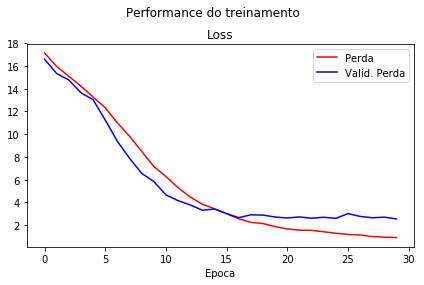

In [89]:
fig, ax = plt.subplots()

plt.plot(hist.history['loss'], color='red')
plt.plot(hist.history['val_loss'], color='blue')
plt.legend(['Perda', 'Valid. Perda'])
plt.xlabel('Epoca')
plt.title('Loss')
plt.tight_layout()

plt.suptitle('Performance do treinamento')

plt.tight_layout()
plt.subplots_adjust(top=0.85)

#### Acurácia

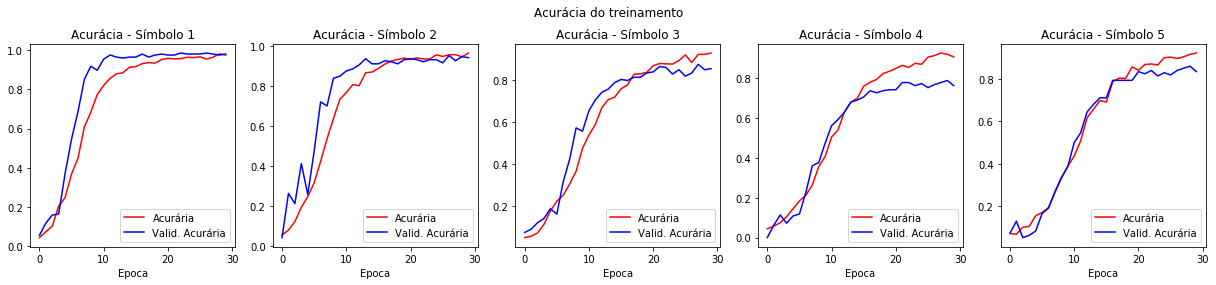

In [95]:
fig, ax = plt.subplots(1, 5, figsize=(17, 4))

plt.sca(ax[0])
plt.plot(hist.history['dense_22_acc'], color='red')
plt.plot(hist.history['val_dense_22_acc'], color='blue')
plt.legend(['Acurária', 'Valid. Acurária'])
plt.xlabel('Epoca')
plt.title('Acurácia - Símbolo 1')

plt.sca(ax[1])
plt.plot(hist.history['dense_24_acc'], color='red')
plt.plot(hist.history['val_dense_24_acc'], color='blue')
plt.legend(['Acurária', 'Valid. Acurária'])
plt.xlabel('Epoca')
plt.title('Acurácia - Símbolo 2')

plt.sca(ax[2])
plt.plot(hist.history['dense_26_acc'], color='red')
plt.plot(hist.history['val_dense_26_acc'], color='blue')
plt.legend(['Acurária', 'Valid. Acurária'])
plt.xlabel('Epoca')
plt.title('Acurácia - Símbolo 3')

plt.sca(ax[3])
plt.plot(hist.history['dense_28_acc'], color='red')
plt.plot(hist.history['val_dense_28_acc'], color='blue')
plt.legend(['Acurária', 'Valid. Acurária'])
plt.xlabel('Epoca')
plt.title('Acurácia - Símbolo 4')

plt.sca(ax[4])
plt.plot(hist.history['dense_30_acc'], color='red')
plt.plot(hist.history['val_dense_30_acc'], color='blue')
plt.legend(['Acurária', 'Valid. Acurária'])
plt.xlabel('Epoca')
plt.title('Acurácia - Símbolo 5')

plt.suptitle('Acurácia do treinamento')

plt.tight_layout()
plt.subplots_adjust(top=0.85)

### Conclusão

Esta forma de organização da rede neural convolucional, separando diferentes ramos para identificação de cada uma das letras presentes no CAPTCHA se mostrou bastante eficaz, com acurácia final sempre superior a 90%.

O ponto negativo desta forma de organização da rede e da base de dados é a dificuldade de se realizar um aumento do conjunto de dados por meio do ImageDataGenerator do Keras. Esta pequena base de dados nos levou a um grande risco de sobreajuste da rede. 

Como objetivo para um próximo trabalho resta esta oportunidade de realizar este aumento artificial, ou não, dos dados, seja por meio de outras bibliotecas, seja por mudanças na arquitetura da rede.

### Dados e referências

Base de dados utilizada

https://www.kaggle.com/fournierp/captcha-version-2-images

Proposta de resolução

https://www.kaggle.com/shawon10/captcha-recognition/notebook